<img src='logo.png' width='100%' height='40'><br>
    ref URL : <a href='https://www.kaggle.com/c/house-prices-advanced-regression-techniques'>https://www.kaggle.com/c/house-prices-advanced-regression-techniques</a>"

<pre>
<b>
* 회귀(Regrassion) 란?
둘 사이의 상관관계를 모델링하는 기법( Y = w₁X₁ + w₂X₂ + ... )
w(weight) = 회귀계수(Coefficient) 또는 가중치(Weight)
Fiture와 결정값 학습을 통해 최적의 회귀계수를 찾는 것.
</b>
*독립변수 개수
  # 1개 : 단일회귀
  # 多  : 다중회귀
*회귀계수 결합
  # 선형회귀 (가장 많이 사용. 규제 방법에 따라 유형 나뉨)
  # 비선형회귀
  </pre>

<pre>
<font color='red'>
* 분석절차</font>
1. EDA
  - dataframe 타입별(카테고리형/수치형) 피쳐 분류<br>
2. 결측치 확인/피쳐삭제/채우기
  - 결측값 대체(수치형:평균 / Object형:'None')
  
3. 수치형 피쳐 데이터값 확인
  - target 피쳐 분리
  - unique ID 피쳐 삭제
  
4. 수치형 피쳐 상관분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석
  - target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인
  
5. 수치형 피쳐 인코딩
  - 인코딩(수치형:unique[:13]
  
6. 수치형 정규화
  - 타켓 분포도 확인/정규화
  - 정규화/스케일 (수치형:skew[:25] 로그변환
  
7. Object형 시각화

8. Outlier 처리
  -아웃라이어제거(수치형:IQR) 
  
9. Object형 피쳐 인코딩

10. 학습모델 선정 / 평가

11. 검증 / 튜닝
</pre>          

## Library & API

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from scipy.stats import skew #왜도
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings(action="ignore")

%matplotlib inline

## 분석 데이터 로드

In [87]:
df = pd.read_csv("train.csv")
print(df.shape)

(1460, 81)


## 1. dataframe 타입별(카테고리형/수치형) 피쳐 분류

In [88]:

def type_check(df):
    object_feature = df.dtypes[df.dtypes == 'object'].index
    #object_feature = df.select_dtypes(include = ["object"]).columns
    numeric_feature = df.dtypes[df.dtypes != 'object'].index
    # numeric_column = df.columns - object_column
    print(df.dtypes.value_counts())
    print("object type:",object_feature)  #숫치형->범주화/인코딩
    print("numeric type:",numeric_feature) #스케일,범주화
    return object_feature, numeric_feature

object_feature, numeric_feature = type_check(df)


object     43
int64      35
float64     3
dtype: int64
object type: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
numeric type: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea

## 2. 결측치 확인/피쳐삭제/채우기
* 대량의 피쳐 분석의 경우 : 결측치 피쳐 삭제부터

In [89]:
# ---------- dataframe 결측치 확인/제거
def null_feature_check(df, drop_cnt=None):
    isnull_feature = df.isnull().sum()[df.isnull().sum()>0].index
    null_df = pd.DataFrame()
    null_df["null_cnt"]  = df[isnull_feature].isnull().sum()
    null_df["null_rate"]  = df[isnull_feature].isnull().sum() / df.shape[0] * 100
    print(null_df)

    # FireplaceQu     690 47.260274  --- 모델 평가 후 재검토 필요
    if drop_cnt != None :
        drop_isnull_feature = df.isnull().sum()[df.isnull().sum() > drop_cnt].index
        #['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
        print("\ndrop_feature:",drop_isnull_feature)

        # df.drop(drop_isnull_feature, axis=1, inplace=True)
        df = df.drop(drop_isnull_feature, axis=1)
        print(df.shape)  #(1460, 76)
    return df

df = null_feature_check(df)
df = null_feature_check(df, 600)

              null_cnt  null_rate
LotFrontage        259  17.739726
Alley             1369  93.767123
MasVnrType           8   0.547945
MasVnrArea           8   0.547945
BsmtQual            37   2.534247
BsmtCond            37   2.534247
BsmtExposure        38   2.602740
BsmtFinType1        37   2.534247
BsmtFinType2        38   2.602740
Electrical           1   0.068493
FireplaceQu        690  47.260274
GarageType          81   5.547945
GarageYrBlt         81   5.547945
GarageFinish        81   5.547945
GarageQual          81   5.547945
GarageCond          81   5.547945
PoolQC            1453  99.520548
Fence             1179  80.753425
MiscFeature       1406  96.301370
              null_cnt  null_rate
LotFrontage        259  17.739726
Alley             1369  93.767123
MasVnrType           8   0.547945
MasVnrArea           8   0.547945
BsmtQual            37   2.534247
BsmtCond            37   2.534247
BsmtExposure        38   2.602740
BsmtFinType1        37   2.534247
BsmtFinType2  

In [90]:

# def objct_type_fillna(df, object_feature):
#     #불가능
#     df.fillna('None', inplace=True)
#     #불가능
#     df.fillna(np.nan).replace(np.nan, 'None', inplace=True)
#     #가능
#     for col in object_feature:
#         df[col].fillna('None', inplace=True)
#
# def numeric_type_fillna(df, numeric_feature):
#     #가능
#     df.fillna(df.mean(), inplace=True)
#     #가능
#     for col in numeric_feature:
#         df[col].fillna(df[col].mean(), inplace=True)


In [91]:
# ---------- dataframe 결측치 채우기 / 최종확인
# objct_type_fillna(df, object_feature)
# numeric_type_fillna(df, numeric_feature)
df.fillna(df.mean(), inplace=True)
df.replace(np.nan, 'None', inplace=True)
df = null_feature_check(df)

Empty DataFrame
Columns: [null_cnt, null_rate]
Index: []


## 3. 수치형 피쳐 데이터값 확인

In [92]:
df[numeric_feature].head(10).T

,0,1,2,3,4,5,6,7,8,9
Id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.000000,9.0,10.0
MSSubClass,60.0,20.0,60.0,70.0,60.0,50.0,20.0,60.000000,50.0,190.0
LotFrontage,65.0,80.0,68.0,60.0,84.0,85.0,75.0,70.049958,51.0,50.0
LotArea,8450.0,9600.0,11250.0,9550.0,14260.0,14115.0,10084.0,10382.000000,6120.0,7420.0
OverallQual,7.0,6.0,7.0,7.0,8.0,5.0,8.0,7.000000,7.0,5.0
OverallCond,5.0,8.0,5.0,5.0,5.0,5.0,5.0,6.000000,5.0,6.0
YearBuilt,2003.0,1976.0,2001.0,1915.0,2000.0,1993.0,2004.0,1973.000000,1931.0,1939.0
YearRemodAdd,2003.0,1976.0,2002.0,1970.0,2000.0,1995.0,2005.0,1973.000000,1950.0,1950.0
MasVnrArea,196.0,0.0,162.0,0.0,350.0,0.0,186.0,240.000000,0.0,0.0
BsmtFinSF1,706.0,978.0,486.0,216.0,655.0,732.0,1369.0,859.000000,0.0,851.0


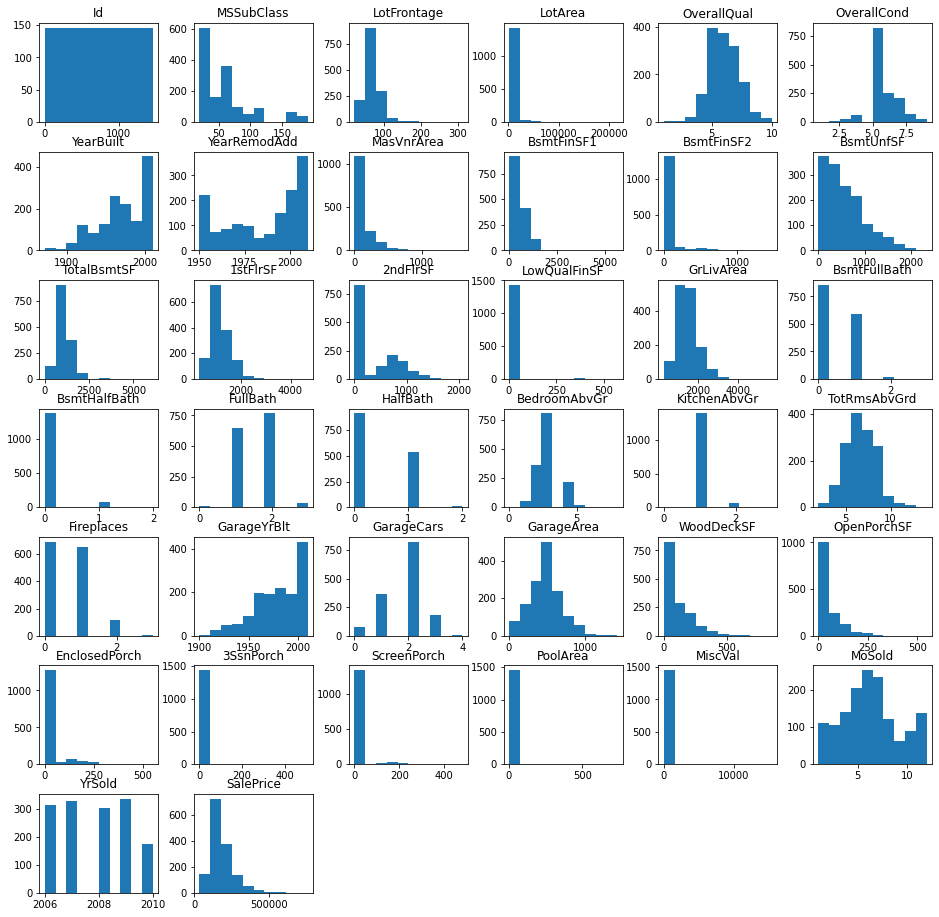

In [93]:
df.hist(bins=10, figsize=(16,16), grid=False);
plt.show()

### unique ID 피쳐 삭제

In [94]:
df.drop('Id', axis=1, inplace=True)


numeric_feature = df.dtypes[df.dtypes != 'object'].index  #pandas.core.indexes.base.Index
print(numeric_feature)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


## 4. 수치형 피쳐 상관분석

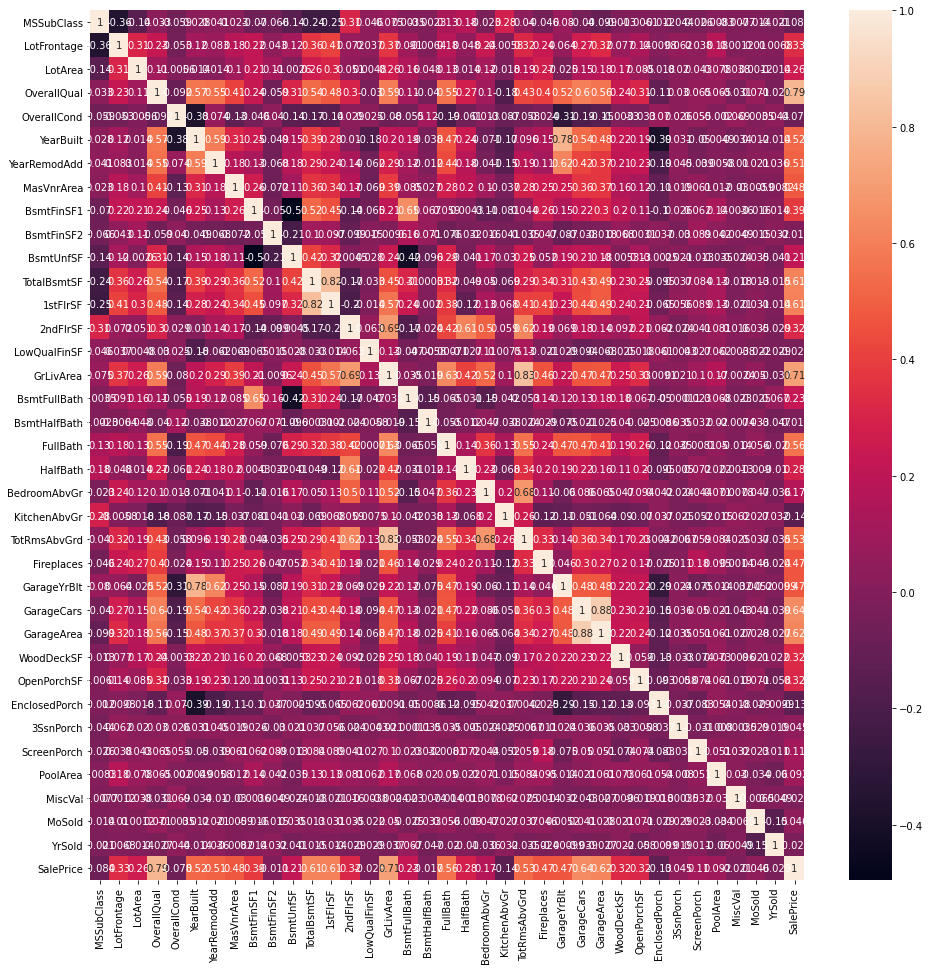

In [95]:
## 수치형 피쳐 상관분석
plt.figure(figsize=(16,16))
sns.heatmap(df[numeric_feature].corr(), annot=True)
plt.show()

#### target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 상관 분석

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'GarageYrBlt', 'Fireplaces',
       'BsmtFinSF1'],
      dtype='object')


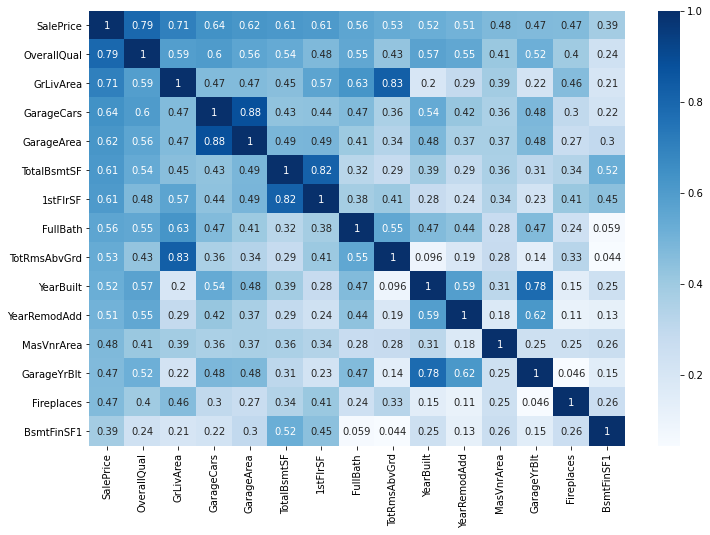

In [96]:
saleprice_corr_feature  = df[numeric_feature].corr().nlargest(15, 'SalePrice').index
print(saleprice_corr_feature)
plt.figure(figsize=(12,8))
sns.heatmap(df[saleprice_corr_feature].corr(), annot=True, cmap='Blues')
plt.show()

** 상관분석 결과 다중공선 우려<pre>
'SalePrice' :  'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 
               'YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF', 'GarageYrBlt', 'TotRmsAbvGrd',
               'Fireplaces', 'OpenPorchSF', 'MasVnrArea'
'SalePrice' 'OverallQual' : 'GrLivArea', 
'GarageCars'  : 'GarageArea' 
'YearBuilt' :  'GarageYrBlt',  'YearRemodAdd'
'TotalBsmtSF'  '1stFlrSF'
'FullBath':  'GrLivArea'
'YearRemodAdd' : 'YearBuilt',  'YearRemodAdd'</pre>


In [97]:
# cm = np.corrcoef(df[].values.T) #(1285, 1285)  #(15, 15)
# dd = pd.DataFrame(cm)
# dd.tail()

#### target(SalePrice)에 영향을 주는 상위 n개 피쳐에 대해서만 데이터 분포도(산점도) 확인

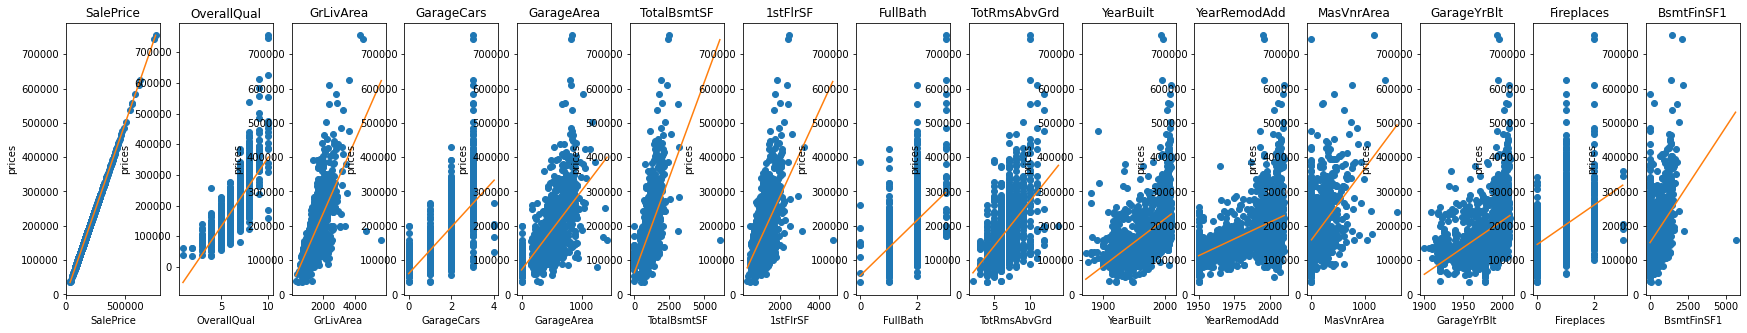

In [98]:
#saleprice_corr_feature = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea','YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF', 'GarageYrBlt', 'TotRmsAbvGrd']
plt.figure(figsize=(30,5))
# i: index
for i, col in enumerate(saleprice_corr_feature):
    
    # 3 plots here hence 1, 3
    plt.subplot(1, len(saleprice_corr_feature), i+1)
    x = df[col]
    y = df['SalePrice']
    plt.plot(x, y, 'o')
    
    # Create regression Line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')
    
    

## 5. 수치형 피쳐 인코딩

<pre>
원-핫 인코딩은 간단히 말해 한 개의 요소는 True, 나머지 요소는 False로 만들어 주는 기법이다.

※ 원-핫 인코딩이 필요한 이유?
scikit-learn에서 제공하는 머신러닝 알고리즘은 문자열 값을 입력 값으로 허락하지 않기 때문에 모든 문자열 값들을 숫자형으로 인코딩하는 전처리 작업(Preprocessing) 후에 머신러닝 모델에 학습을 시켜야 한다.

scikit-learn 에서 제공하는 머신러닝 알고리즘에 데이터를 넣을 수 있는 기본 조건은 다음과 같다.
– 모든 데이터는 숫자(정수형, 실수형 등)로 구성되어 있어야 한다.
– 데이터에 빈 값이 없어야 한다.
</pre>

<img src='https://miro.medium.com/max/700/0*PO_ENSfL80nPRqIg'>

In [99]:
# select distinct deptno from emp;
#수치형 : 0/1/2 코드성 수치
oh_numeric_feature = []
for col in numeric_feature:
    if df[col].nunique() <= 15:
        print(col, df[col].unique())
        oh_numeric_feature.append(col)
print("인코딩 적용 전 :",df.shape)

oh_numeric_feature.remove('MSSubClass')
oh_numeric_feature.remove('PoolArea')
oh_numeric_feature.remove('YrSold')  #??????????????????
print("인코딩 대상 피쳐 :", oh_numeric_feature)

df_oh = pd.get_dummies(data=df, columns=oh_numeric_feature)
print("인코딩 적용 후 :",df_oh.shape)
print(df_oh.head())

MSSubClass [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual [ 7  6  8  5  9  4 10  3  1  2]
OverallCond [5 8 6 7 4 2 3 9 1]
BsmtFullBath [1 0 2 3]
BsmtHalfBath [0 1 2]
FullBath [2 1 3 0]
HalfBath [1 0 2]
BedroomAbvGr [3 4 1 2 0 5 6 8]
KitchenAbvGr [1 2 3 0]
TotRmsAbvGrd [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces [0 1 2 3]
GarageCars [2 3 1 0 4]
PoolArea [  0 512 648 576 555 480 519 738]
MoSold [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold [2008 2007 2006 2009 2010]
인코딩 적용 전 : (1460, 75)
인코딩 대상 피쳐 : ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold']
인코딩 적용 후 : (1460, 141)
   MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   
2          60       RL         68.0    112

## 6. 수치형 정규화

#### 타켓 분포도 확인/정규화

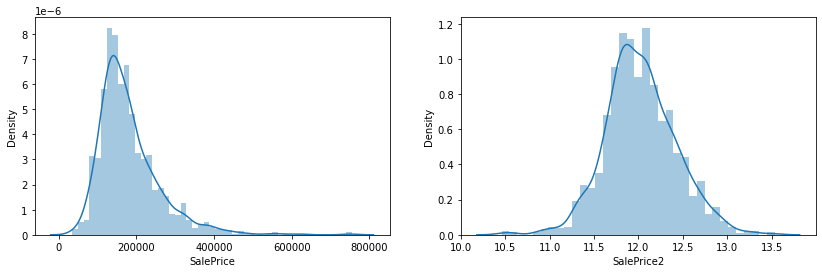

In [100]:
# MinMaxScaler: 0 ~ 1
# StandardScaler: 평균0 분산1(정규분포)
# np.log()
#  : max을 0으로두고 다른값을 뺀 그 차이값을 이용
# np.log1p()
# : log를 취한값이 너무 작으면 언더플로우가 나기 때문에 1을 더해서 사용

df['SalePrice2'] = np.log1p(df['SalePrice'])

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.distplot(df['SalePrice'],  ax=axes[0])
sns.distplot(df['SalePrice2'], ax=axes[1])
plt.show()

#### 수치형 피쳐 : skew() kurt() 왜도/첨도확인
<pre>

왜도(비대칭도)란, 확률변수의 확률분포가 비대칭성을 의미한다
a=0이면 정규분포, a<0이면 오른쪽으로 치우침, a>0이면 왼쪽으로 치우침을 의미한다.

첨도란(Kurtosis), 확률분포의 뾰족한 정도를 의미한다
a=3이면 정규분포, a<3이면 정규분포보다 완만함, a>3이면 정규분포 보다 뾰족함을 의미한다.
</pre>

In [101]:
#============== skew() kurt() 왜도/첨도 확인
sk_df = pd.DataFrame()

# sns.distplot(df[col])
#왜도 : 대칭=0(정규분포) <0 :오른쪽편중  >0:왼쪽편중
sk_df["skew"] = df[numeric_feature].skew()
#첨도 : 뾰족함(중앙 편중)
sk_df["kurt"] = df[numeric_feature].kurt()
print(sk_df.head(40).sort_values("skew", ascending=False))


                    skew        kurt
MiscVal        24.476794  701.003342
PoolArea       14.828374  223.268499
LotArea        12.207688  203.243271
3SsnPorch      10.304342  123.662379
LowQualFinSF    9.011341   83.234817
KitchenAbvGr    4.488397   21.532404
BsmtFinSF2      4.255261   20.113338
ScreenPorch     4.122214   18.439068
BsmtHalfBath    4.103403   16.396642
EnclosedPorch   3.089872   10.430766
MasVnrArea      2.676412   10.154316
LotFrontage     2.384950   21.848165
OpenPorchSF     2.364342    8.490336
SalePrice       1.882876    6.536282
BsmtFinSF1      1.685503   11.118236
WoodDeckSF      1.541376    2.992951
TotalBsmtSF     1.524255   13.250483
MSSubClass      1.407657    1.580188
1stFlrSF        1.376757    5.745841
GrLivArea       1.366560    4.895121
BsmtUnfSF       0.920268    0.474994
2ndFlrSF        0.813030   -0.553464
OverallCond     0.693067    1.106413
TotRmsAbvGrd    0.676341    0.880762
HalfBath        0.675897   -1.076927
Fireplaces      0.649565   -0.217237
B

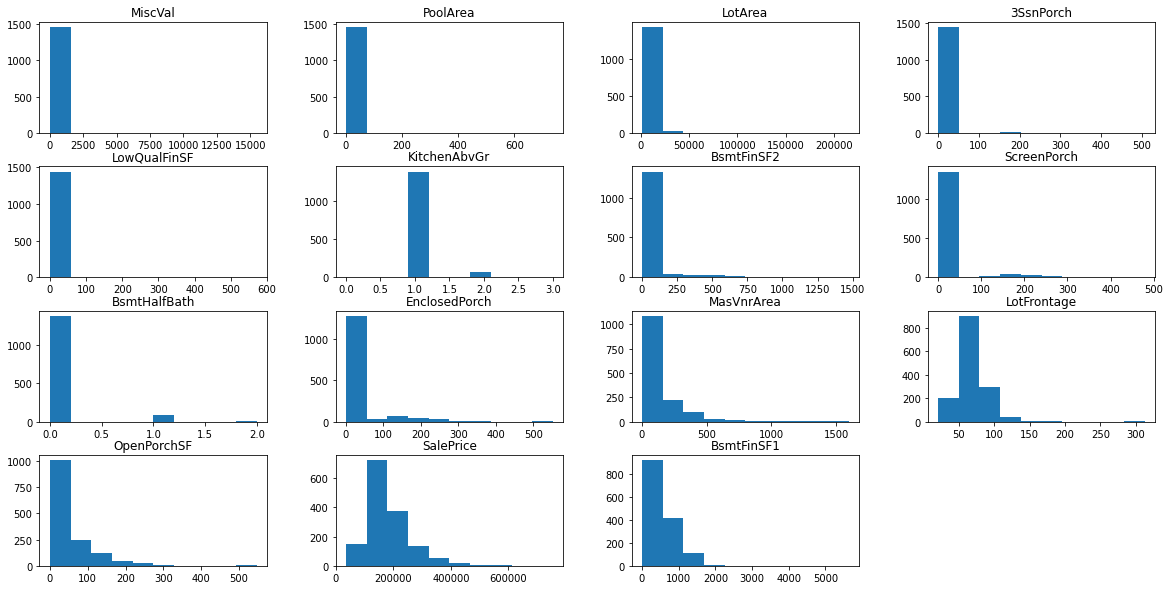

In [102]:
skew_feature = sk_df.head(40).sort_values("skew", ascending=False)[:15].index
skew_feature = skew_feature # - oh_numeric_feature

df[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()


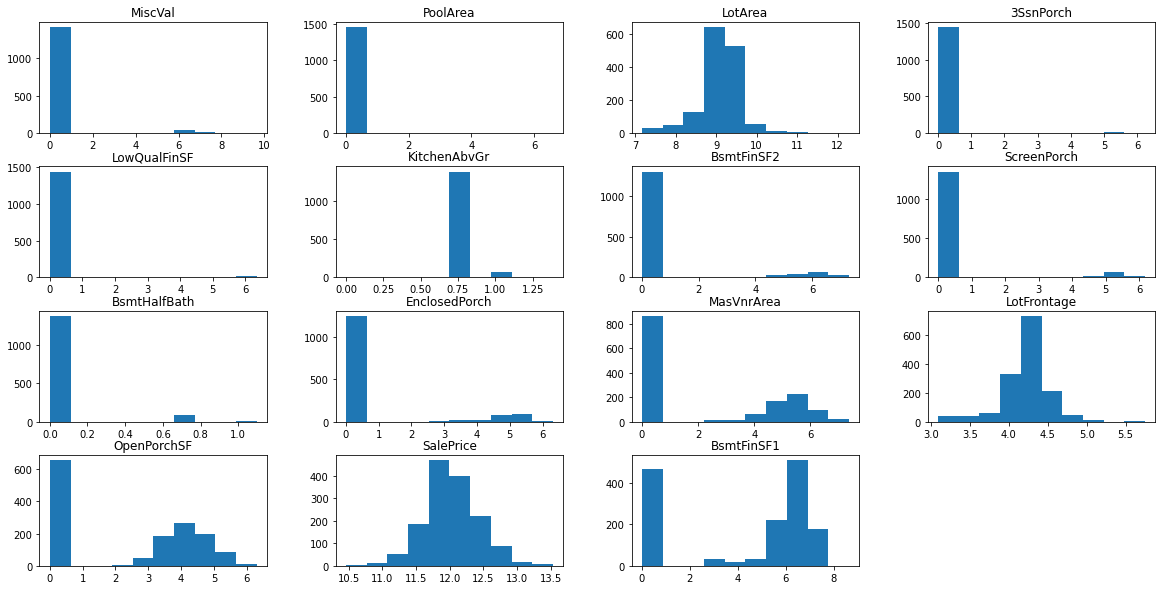

In [103]:
for col in skew_feature:
    df[col] = np.log1p(df[col])
df[skew_feature].hist(bins=10, figsize=(20,10), grid=False)
plt.show()


In [104]:
# SalePrice : OverrallQual YearBuilt YearRemodeAdd GrLiveArea FullBath GarageCars GarageArea 
# BsmtFinSF1 : BsmtUnitSF : BstmtFullBath
# YearBuiltin : EnclosedPoach

# taget 피쳐와 상관관계가 가장 높은 피쳐들을 확인 --> 시각화
# taget 피쳐를 제외한 모든 수치형 피쳐들간에 상관관계  --> 다중공선없엔다(drop대상)


## 7. Object형 시각화

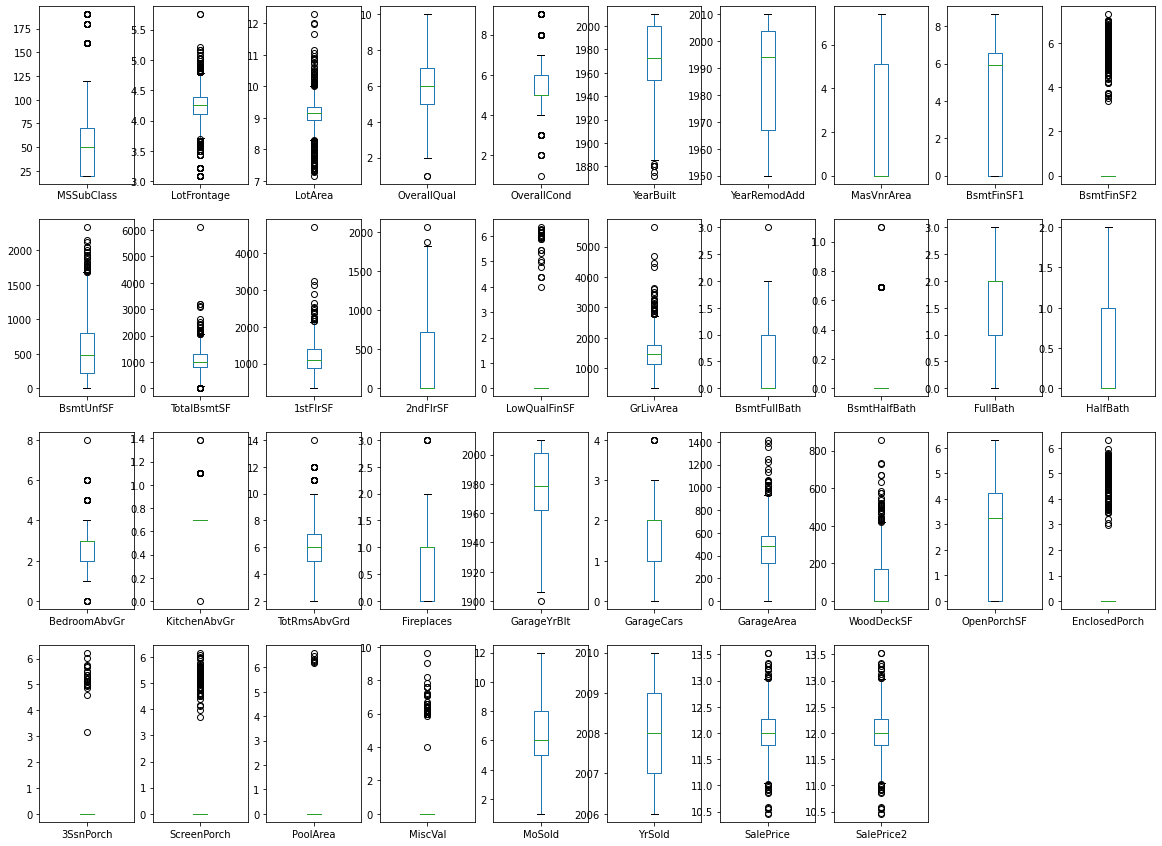

In [105]:
#============== matplot.plt(box)
df.plot(kind='box', subplots=True, figsize=(20, 15), layout=(4,10), sharex=False, sharey=False)
plt.show()

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')


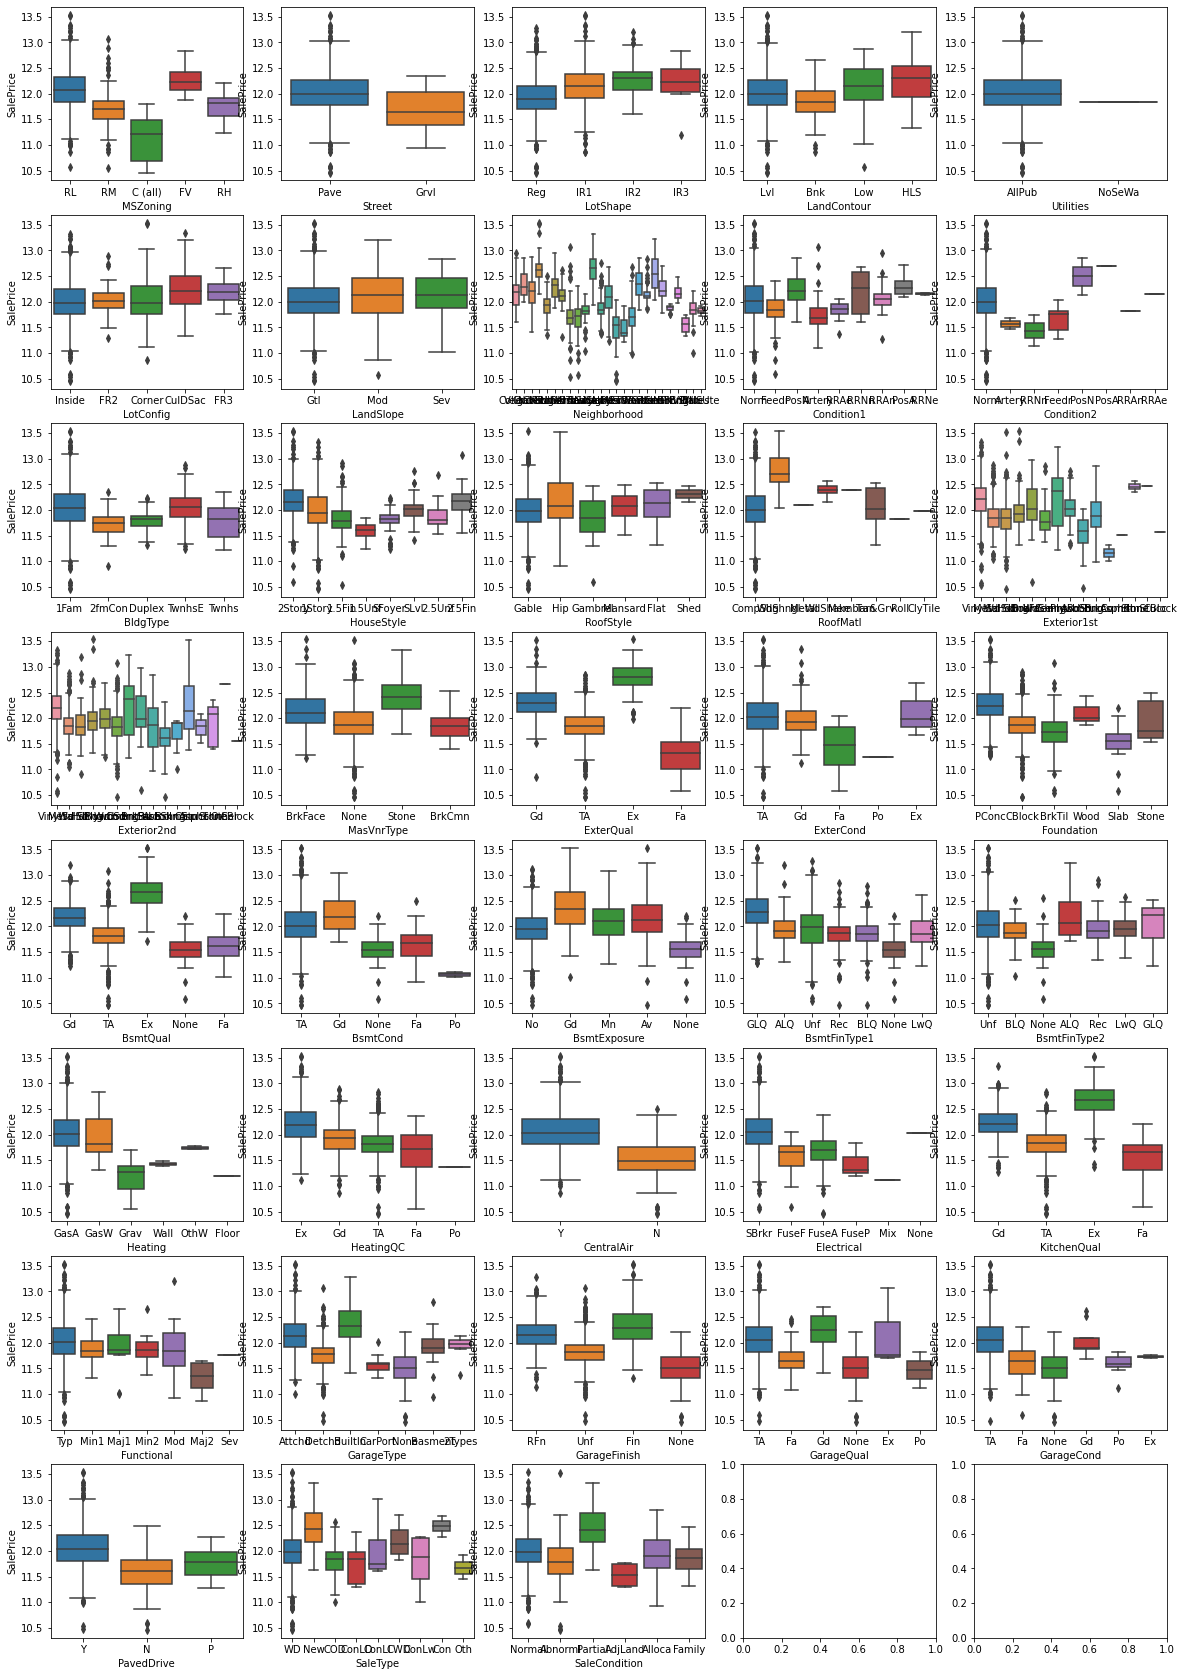

In [106]:
#============== sns.boxplot()
object_feature = df.dtypes[df.dtypes == 'object'].index
print(object_feature)
fig, axs = plt.subplots(figsize=(20,30), ncols=5, nrows=8)
for i, feature in enumerate(object_feature):
    row = int(i / 5) 
    col = i % 5
    # seaborn의 regplot 이용하여 박스플롯
    sns.boxplot(x=feature, y='SalePrice', data=df, ax=axs[row][col])


** target(SalePrice)에 영향을 미치는(각 피쳐별로 값의 중앙값의 편차가 크다) 피쳐 선정<pre>
* 'SalePrice', 상관성이 높은 피쳐(회귀계수)
카테고리(object)형 : 
       'MSZoning', 'Neighborhood', 'Condition1', 'Condition2', 'SaleType'
수치형 : 
       'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'YearBuilt', 'TotalBsmtSF', 'FullBath', 'YearRemodAdd', '1stFlrSF',
       'GarageYrBlt', 'TotRmsAbvGrd', 'Fireplaces', 'OpenPorchSF',
       'MasVnrArea'
*다중공선 해결 <br>
'GarageCars', 'GarageArea',<br>
'GrLivArea','TotRmsAbvGrd'<br>
'GarageYrBlt','YearBuilt'<br>
'1stFlrSF','TotalBsmtSF'<br>

</pre>


## 8. Outlier 탐지

IQR (Inter Quartile Range). IQR 이란 상위 75% 지점의 값과 하위 25 지점의 값 차이를 의미한다.
<pre>
최솟값 : 제 1사분위에서 1.5 IQR1을 뺀 위치이다.
제 1사분위(Q1) : 25%의 위치를 의미한다.
제 2사분위(Q2) : 50%의 위치로 중앙값(median)을 의미한다.
제 3사분위(Q3) : 75%의 위치를 의미한다.
최댓값 : 제 3사분위에서 1.5 IQR을 더한 위치이다.
최솟값과 최댓값을 넘어가는 위치에 있는 값을 이상치(Outlier)라고 부른다.
</pre>
    
<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/1200px-Boxplot_vs_PDF.svg.png' width=500 height=300>

In [107]:
from collections import Counter
def detect_outliers(df, n, features):
    outlier_idx_list = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        IQR15 = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - IQR15) | (df[col] > Q3 + IQR15)].index
        outlier_idx_list.extend(outlier_list_col)
    outlier_idx_list = Counter(outlier_idx_list)
    multiple_outliers = list(k for k, v in outlier_idx_list.items() if v > n)
    return multiple_outliers


In [108]:
outlier_drop_feature = detect_outliers(df, 2, numeric_feature)
print(outlier_drop_feature)

print("Outlier 처리전:", df.shape)
df = df.drop(outlier_drop_feature, axis = 0).reset_index(drop=True)
print("Outlier 처리후:", df.shape)

[48, 56, 75, 93, 115, 125, 145, 165, 172, 193, 195, 225, 227, 232, 235, 246, 335, 344, 348, 363, 430, 432, 434, 472, 489, 500, 504, 520, 578, 599, 603, 614, 635, 649, 655, 675, 703, 705, 755, 758, 829, 831, 837, 914, 915, 956, 959, 962, 971, 1007, 1029, 1030, 1038, 1039, 1062, 1068, 1088, 1091, 1104, 1160, 1190, 1191, 1219, 1236, 1265, 1266, 1291, 1297, 1304, 1334, 1364, 1367, 1378, 1393, 1416, 1449, 1452, 197, 231, 260, 313, 523, 662, 764, 954, 991, 1061, 1173, 1182, 1298, 53, 185, 249, 425, 529, 588, 661, 769, 828, 848, 1169, 1177, 1184, 1325, 1396, 1405, 375, 533, 88, 218, 304, 390, 676, 745, 749, 919, 1006, 1031, 1041, 1076, 1137, 1156, 1213, 1259, 1268, 1320, 1380, 747, 1349, 7, 113, 116, 129, 166, 330, 358, 440, 499, 502, 510, 888, 944, 953, 1024, 1094, 1205, 1230, 1346, 1386, 137, 224, 278, 496, 798, 803, 843, 1046, 17, 178, 691, 897, 898, 1044, 1373, 198, 1440, 118, 324, 961, 1142, 1328, 1350, 634, 910, 912]
Outlier 처리전: (1460, 76)
Outlier 처리후: (1285, 76)


## 9. Object형 피쳐 인코딩

In [109]:
# Object Type : 
# LabelEncoding (Pool Extend ... Excellent : 0 1 ... 33)
# OneHotEncoding (1000 0100  0010 0001) :피쳐가 엄청~ 많아진다(시각화X, 분석용)
# pd.get_dummy()

print("인코딩 적용 전 :",df.shape, df_oh.shape)
df_oh = pd.get_dummies(data=df, columns=object_feature)
print("인코딩 적용 후 :",df_oh.shape)

인코딩 적용 전 : (1285, 76) (1460, 141)
인코딩 적용 후 : (1285, 277)


In [110]:
df_oh.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


## 10. 학습모델 선정 / 평가

In [111]:
y_log = df_oh['SalePrice2']
y = df_oh['SalePrice']
X_oh = df_oh.drop(['SalePrice','SalePrice2'], axis=1)

# ---- 데이터 셋 ------------------------
X_train7, X_test3,  y_train7, y_test3  \
    = train_test_split(X_oh, y_log, test_size=0.3, random_state=11)




In [112]:
y_train7.head()

318     12.198549
678     12.727841
302     12.491255
1157    12.618186
512     11.884496
Name: SalePrice2, dtype: float64

In [113]:
y_train7.head()

318     12.198549
678     12.727841
302     12.491255
1157    12.618186
512     11.884496
Name: SalePrice2, dtype: float64

In [114]:
# ---- 개별 분류 모델 -------------------
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    model.fit(X_train7, y_train7)
    pred = model.predict(X_test3)
    print(model_name , mean_squared_error(y_test3, pred))

LR 0.014042635398285947
Ridge 0.012452294239105733
Lasso 0.030080059822904483


In [116]:
#----- cross_val_score-------

for model_name, model in [("LR", lr), ("Ridge", ridge), ("Lasso", lasso)]:
    neg_mse_scores = cross_val_score(model, X_oh, y_log, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print(model_name, ' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
    print(model_name, ' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores,3))
    print(model_name, ' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))
    print()


LR  5 folds 의 개별 Negative MSE scores:  [-1.10000000e-02 -1.40000000e-02 -1.95879649e+13 -2.24822507e+12
 -1.50000000e-02]
LR  5 folds 의 개별 RMSE scores :  [1.07000000e-01 1.19000000e-01 4.42582929e+06 1.49940824e+06
 1.22000000e-01]
LR  5 folds 의 평균 RMSE : 1185047.576 

Ridge  5 folds 의 개별 Negative MSE scores:  [-0.01  -0.013 -0.016 -0.012 -0.013]
Ridge  5 folds 의 개별 RMSE scores :  [0.1   0.115 0.127 0.108 0.115]
Ridge  5 folds 의 평균 RMSE : 0.113 

Lasso  5 folds 의 개별 Negative MSE scores:  [-0.023 -0.028 -0.029 -0.027 -0.027]
Lasso  5 folds 의 개별 RMSE scores :  [0.15  0.167 0.171 0.164 0.166]
Lasso  5 folds 의 평균 RMSE : 0.163 



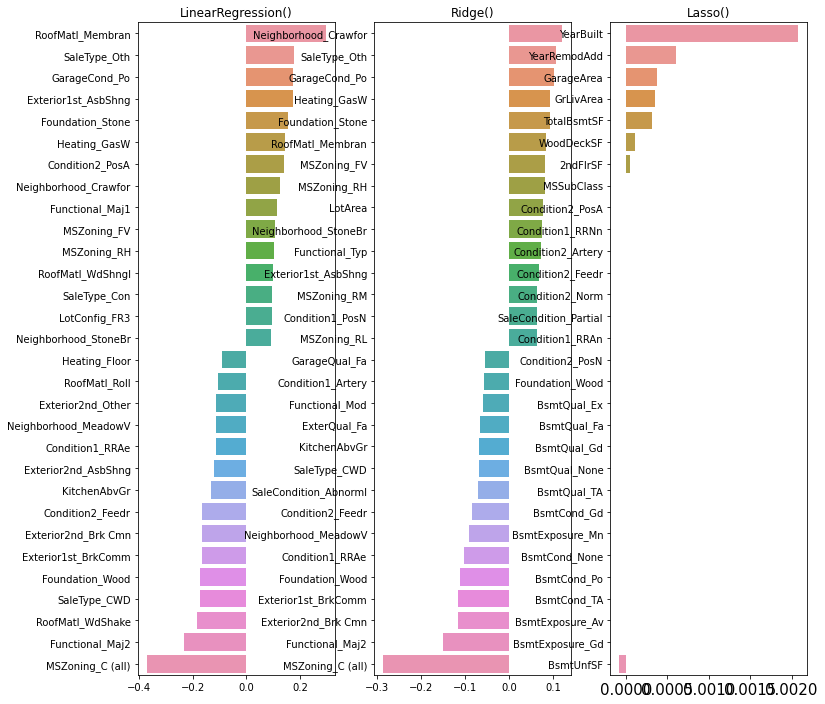

In [135]:

# 각 모델에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
models = [lr, ridge, lasso]
    
fig , axs = plt.subplots(figsize=(12,12) , nrows=1 , ncols=3)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성  
coef_df = pd.DataFrame()
plt.xticks(fontsize=15)

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos , model in enumerate(models) :
    model.fit(X_train7, y_train7)
    # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 컬럼으로 추가.  
    coef = pd.Series(data=model.coef_ , index=X_train7.columns )
    coef_head = coef.sort_values(ascending=False).head(15)
    coef_tail = coef.sort_values(ascending=False).tail(15)
    coef = pd.concat([coef_head, coef_tail])
    coef_df[model] = coef
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현--------------------추가코드
    coef = coef.sort_values(ascending=False)
    axs[pos].set_title(model)
    
#     axs[pos].set_xlim(-0.2,0.2)
    sns.barplot(x=coef.values , y=coef.index, ax=axs[pos])
# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시

plt.show()


## 13.모델 검증 및 튜닝

In [146]:
myprm = {'alpha':[0.05,0.1,0.5,1.0,3.0,10.0, 20.0]}
best_model = GridSearchCV(ridge, param_grid=myprm,
             scoring="neg_mean_squared_error",verbose=0,
             refit=True, cv=5)
best_model.fit(X_train7, y_train7)
print("베스트 점수:",best_model.best_score_)
print("베스트 파라미터:",best_model.best_params_)

best_pred = best_model.predict(X_test3)
mse = mean_squared_error(y_test3, best_pred)
print(mse, np.sqrt(mse))

-0.012294136340277909
{'alpha': 10.0}
0.012195743872277655 0.11043434190630039


* best_param 중심으로 튜닝 값 재조정
* alpha값 변화를 시각화해서 확인

In [156]:
print("submit시 제출할 예측 집값(로그변환값) :\n", best_pred[:5])
print("원본값으로 변환:\n", np.round(np.expm1(best_pred),0)[:5])

submit시 제출할 예측 집값(로그변환값) :
 [12.38033694 11.90529728 11.9239789  12.0923978  12.13544742]
원본값으로 변환:
 [238073. 148048. 150840. 178509. 186361.]


In [150]:
myprm = [1.0, 1,5,8.0,9.0,10.0,11.0,12.0,15,20,50]
score_list = []
for ap in myprm:
    ridge = Ridge(alpha=ap)
    neg_mse_scores5 = cross_val_score(ridge, X_oh, y_log, 
                scoring="neg_mean_squared_error", cv = 5)
    rmse_scores5  = np.sqrt(-1 * neg_mse_scores5)
    avg_rmse = np.mean(rmse_scores5)
    print(avg_rmse)  
    score_list.append(avg_rmse)

0.11290625386591358
0.11290625386591358
0.1108910509740908
0.11082421857765692
0.11083346790615205
0.11085002151777457
0.11087176218884309
0.11089734090531149
0.11098940063608782
0.1111717051951064
0.11244345210747268


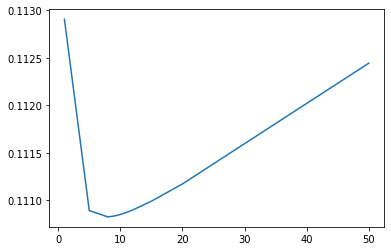

In [151]:
plt.plot(myprm, score_list)
plt.show()